# **Biased Quadratic** response function via a **swap test** routine.


 
To run without manually installing additional packages:


*   Upload to your Google Drive account;
*   Open with Colab;
*   From the Runtime menu in the upper left corner, execute Run all.





Install Qiskit:




In [ ]:
!pip install qiskit   # when running the code over again, comment this line, unless the kernel is restarted
!pip install pylatexenc   # when running the code over again, comment this line, unless the kernel is restarted
import numpy as np

Import necessary dependencies:

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, assemble, Aer
import numpy as np
from qiskit.visualization import plot_histogram, plot_bloch_vector
from math import sqrt, pi

Consider Bars-and-Stripes (BAS) samples [1] of size 2x2: 
* Samples containing horizontal bars are labeled as positive, and the remainder of the pattern are labeled as negative.

In [ ]:
train_inputs = np.array([[-1, -1, -1, -1], [-1, -1, -1, 1], [-1, -1, 1, -1], [-1, 1, -1, -1], [1, -1, -1, -1], [-1, -1, 1, 1], [-1, 1, -1, 1], [1, -1, -1, 1], [-1, 1, 1, -1], [1, -1, 1, -1], [1, 1, -1, -1], [-1, 1, 1, 1], [1, -1, 1, 1], [1, 1, -1, 1], [1, 1, 1, -1], [1, 1, 1, 1]])
train_outputs = np.array([[-1, -1, -1, -1, -1, 1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1]]).T

The BQ response function can be implemented using the SWAP test routine [2],  summerised as follows:

*   The input and the weight vectors are encoded using amplitude encoding, using separate registers, resulting in the respective quantum states \begin{align}\left|\Psi_x\right\rangle\end{align} and \begin{align}\left|\Psi_w\right\rangle\end{align}
*   A Hadamard gate is applied on the ancilla in the first register, leading to
\begin{align} \frac{1}{\sqrt{2}} (\left|0\right\rangle + \left|1\right\rangle) \left|\Psi_w\right\rangle \left|\Psi_x\right\rangle \end{align}
*   A swap operator is applied on the two registers and we have \begin{align} \frac{1}{\sqrt{2}} (\left|0\right\rangle \left|\Psi_w\right\rangle \left|\Psi_x\right\rangle + \left|1\right\rangle \left|\Psi_w\right\rangle \left|\Psi_x\right\rangle)\end{align}
*   A second Hadamard is applied to the ancilla resulting in \begin{align} \frac{1}{2} \left|0\right\rangle \otimes (\left|\Psi_w\right\rangle \left|\Psi_x\right\rangle +\left|\Psi_x\right\rangle \left|\Psi_w\right\rangle) + \frac{1}{2} \left|1\right\rangle \otimes (\left|\Psi_w\right\rangle \left|\Psi_x\right\rangle -\left|\Psi_x\right\rangle \left|\Psi_w\right\rangle)\end{align}

The outcome is obtained via a projective measurement on the ancila, resulting in the acceptance probability \begin{align} p = \frac{1}{2} + \frac{1}{2} \left|⟨\Psi_w|\Psi_x\right\rangle|^2\end{align}



Now let's build the circuit:

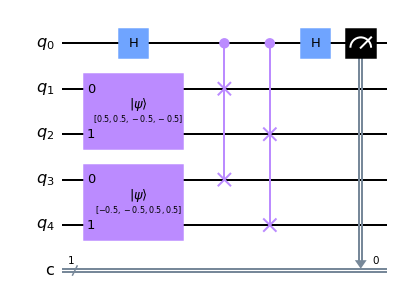

In [ ]:
sample = 10  # select a sample in the range from 0 to 2^(2x2) - 1; note that, 5 and 10 correspond to positive samples, the remaining are negative 

num_qubits = 2   # 2 qubits are needed for 2x2 BAS input
circuit1 = QuantumCircuit(num_qubits)   # amplitude encoding circuit for the input samples
initial_state_input = train_inputs[sample]/np.sqrt(4)   # note that, the amplitudes must be normalised
circuit1.initialize(initial_state_input, circuit1.qubits)

circuit2 = QuantumCircuit(num_qubits)   # amplitude encoding circuit for the weights
initial_state_weight = [-1, -1, 1, 1]/np.sqrt(4)   # this is the optimal weight vector for 2x2 BAS; note that, the amplitudes must be normalised  
circuit2.initialize(initial_state_weight, circuit2.qubits)
    
swap_test_circuit = QuantumCircuit(2*num_qubits + 1,1)   # compiles the encoding circuits, plus adds the ancilla qubit
swap_test_circuit.compose(circuit1, qubits=[1,2], inplace=True )
swap_test_circuit.compose(circuit2, qubits=[3,4], inplace=True )

swap_test_circuit.h(0)   # applies a Hadamard gate to the ancilla qubit

for i in range(num_qubits):   # swaps the qubits in the two registers
    swap_test_circuit.cswap(0,i+1,i+3)   

swap_test_circuit.h(0)   # applies a second Hadamard gate to the ancilla qubit

swap_test_circuit.measure([0],[0])   # performs a measurement on the ancilla

swap_test_circuit.draw(output='mpl')   # visualise the complete circuit


Run the circuit:

In [ ]:
svsim = Aer.get_backend('aer_simulator') 

swap_test_circuit.save_statevector() # saves the current state vector
qobj = assemble(swap_test_circuit) # assembles the circuit in the previous cell (i.e., serializes the operations)
result = svsim.run(qobj).result() # runs the assembeled circuit and returns the outcomes of the measurements


Return the probability of a positive sample:

In [ ]:
quantum_result = result.get_counts()
q_key = "0" 
values_of_q_key = quantum_result [q_key] 
print('Quantum probability of a positive sample:', values_of_q_key/1024)   # default value for the number of repeated measurements is 1024

Quantum probability of a positive sample: 1.0


Compare the result obtained using the quantum routine with a classicaly computed probability. 
* If the routine is sucessful, the quantum result in the previous cell and the classicaly computed probability are similar.

In [ ]:
classical_result = 1/2 + (1/2)*((np.dot(initial_state_input, initial_state_weight)))**2
print('Classical probability of a positive sample:', classical_result)

Classical probability of a positive sample: 1.0


Reveal the true label:

In [ ]:
label = 'positive' if train_outputs[sample] == 1 else 'negative'
print('True label:', label)

True label: positive


# References

[1]  F. Tacchino, C. Macchiavello, D. Gerace, and D. Bajoni, *An artificial neuron  implemented  on  an  actual  quantum  processor,* npj  QuantumInformation, vol. 5, no. 1, pp. 1–8, 2019.

[2] M. Schuld and F. Petruccione, *Machine Learning with Quantum Computers*,    Springer, 2021.